In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.estela import Predictor
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import TWL_WavesFamilies, TWL_AnnualMaxima, Aggregate_WavesFamilies, Intradaily_Hydrograph


In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('TESTNEW')


In [3]:
# --------------------------------------
# Load data for climate emulator fitting: waves partitions and families, KMA, DWT

xds_WVS_pts = db.Load_WAVES_partitions()       # waves partitions data (hourly)
xds_WVS_fam = db.Load_WAVES_fams_noTCs()       # wave families sea, swell_1, swell_2 (TCs removed)
xds_KMA = db.Load_ESTELA_KMA()                 # ESTELA predictor KMA

d_WT_TCs_wvs = db.Load_WAVES_fams_TCs_categ()  # TCs-window waves-families data by category

# --------------------------------------
# Load data for climate emulator simulation: ESTELA DWT and TCs (MU, TAU) 

xds_DWT = db.Load_ESTELA_DWT_sim()

xds_TCs_params = db.Load_TCs_r2_sim_params()    # TCs parameters (copula generated) 
xds_TCs_RBFs = db.Load_TCs_sim_r2_rbf_output()  # TCs numerical_IH-RBFs_interpolation output

xds_probs_TCs =  db.Load_TCs_probs_synth()      # TCs synthetic probabilities
pchange_TCs = xds_probs_TCs['category_change_cumsum'].values[:]

xdsets_mutau_wt = db.Load_MU_TAU_hydrograms()   # MU - TAU intradaily hidrographs for each WWT
MU_WT = np.array([x.MU.values[:] for x in xdsets_mutau_wt])  # MU and TAU numpy arrays
TAU_WT = np.array([x.TAU.values[:] for x in xdsets_mutau_wt])
 

In [4]:
# --------------------------------------
# MATLAB TEST DATA 
# TODO: delete

from teslakit.io.matlab import ReadMatfile
from teslakit.custom_dateutils import datevec2datetime as d2d
from teslakit.custom_dateutils import DateConverter_Mat2Py as dmp

# Test data storage
p_test = op.join(p_data, 'tests', 'ClimateEmulator', 'ml_jupyter')

# load test KMA (bmus, time, number of clusters, cenEOFs)
p_bmus = op.join(p_test, 'bmus_testearpython.mat')
dmatf = ReadMatfile(p_bmus)
xds_KMA = xr.Dataset(
    {
        'bmus'       : ('time', dmatf['KMA']['bmus']),
        'cenEOFs'    : (('n_clusters', 'n_features',), dmatf['KMA']['cenEOFs']),
    },
    coords = {'time' : np.array(d2d(dmatf['KMA']['Dates']))}
)

# DWTs (Daily Weather Types simulated using ALR)
p_DWTs = op.join(p_test, 'DWT_1000years_mjo_awt_v2.mat')
dm_DWTs = ReadMatfile(p_DWTs)
xds_DWT = xr.Dataset(
    {
        'evbmus_sims' : (('time', 'n_sim'), dm_DWTs['bmusim'].T),
    },
    coords = {'time' : dmp(dm_DWTs['datesim'])}
)

# get WTs37, 42 from matlab file
p_WTTCs = op.join(p_test, 'KWA_waves_2PART_TCs_nan.mat')
dm_WTTCs = ReadMatfile(p_WTTCs)

# Load TCs-window waves-families data by category
d_WTTCs = {}
for i in range(6):

    k = 'wt{0}'.format(i+1+36)
    sd = dm_WTTCs[k]

    d_WTTCs['{0}'.format(i+1+36)] = xr.Dataset(
        {
            'sea_Hs'      : (('time',), sd['seaHs']),
            'sea_Dir'     : (('time',), sd['seaDir']),
            'sea_Tp'      : (('time',), sd['seaTp']),
            'swell_1_Hs'  : (('time',), sd['swl1Hs']),
            'swell_1_Dir' : (('time',), sd['swl1Dir']),
            'swell_1_Tp'  : (('time',), sd['swl1Tp']),
            'swell_2_Hs'  : (('time',), sd['swl2Hs']),
            'swell_2_Dir' : (('time',), sd['swl2Dir']),
            'swell_2_Tp'  : (('time',), sd['swl2Tp']),
        }
    )


In [5]:
# --------------------------------------
# Climate Emulator extremes model fitting

# climate emulator object
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)

# Waves and KMA bmus data share time dimension
xds_WVS_fam = xds_WVS_fam.sel(time=xds_KMA.time)
xds_WVS_pts = xds_WVS_pts.sel(time=xds_KMA.time)


# Fit extremes model
config = {
    'name_fams':       ['sea', 'swell_1', 'swell_2'],
    'force_empirical': ['sea_Tp'],
}
CE.FitExtremes(xds_KMA, xds_WVS_pts, xds_WVS_fam, config)


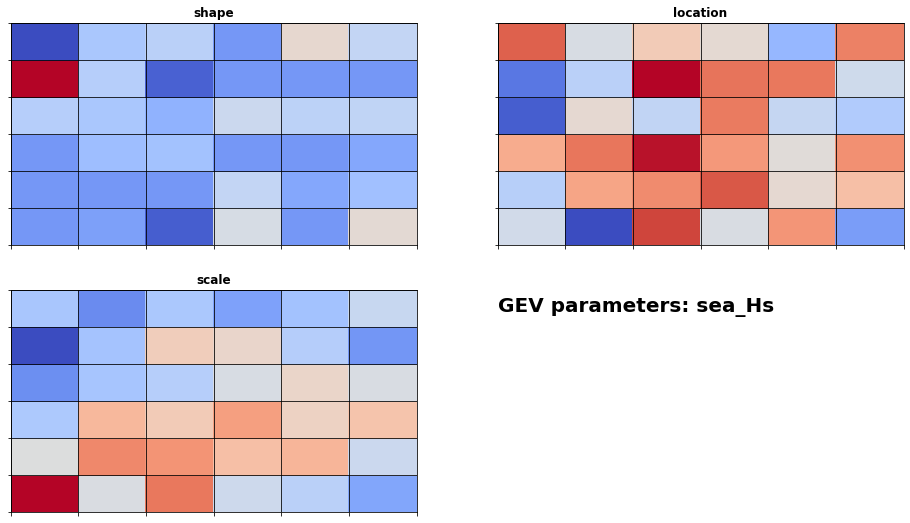

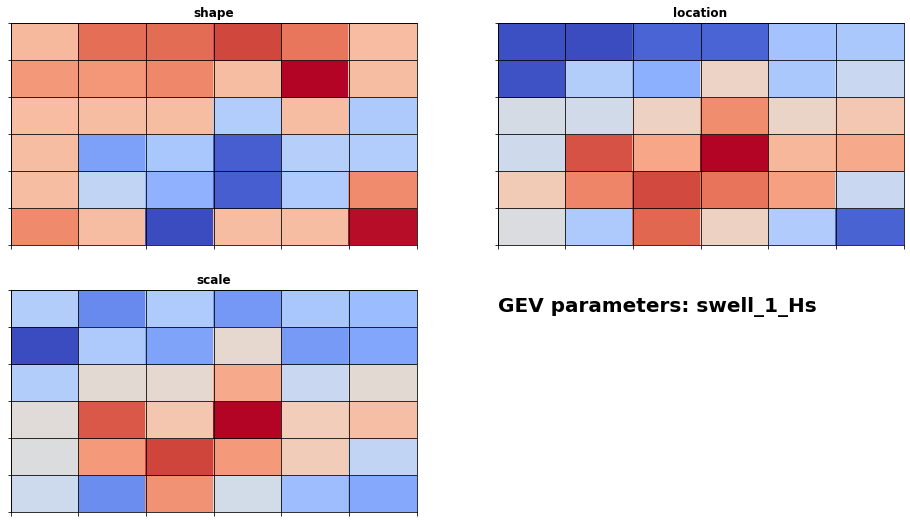

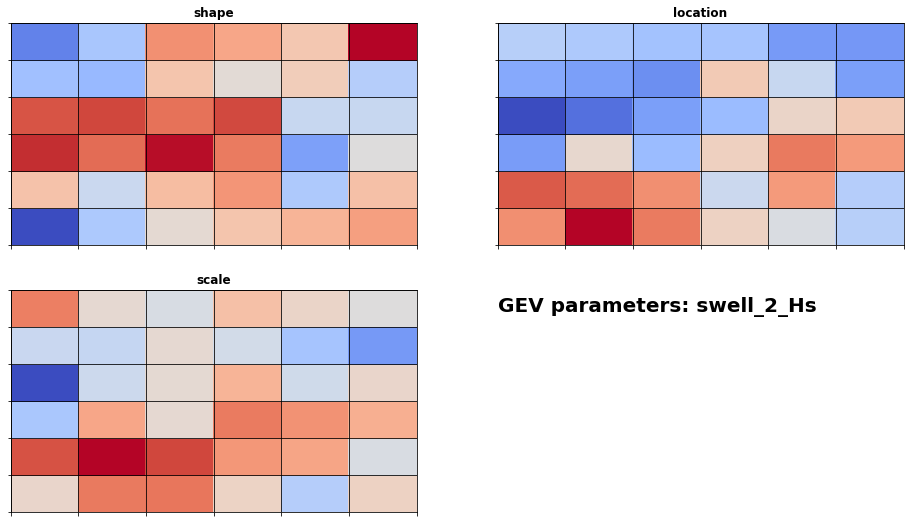

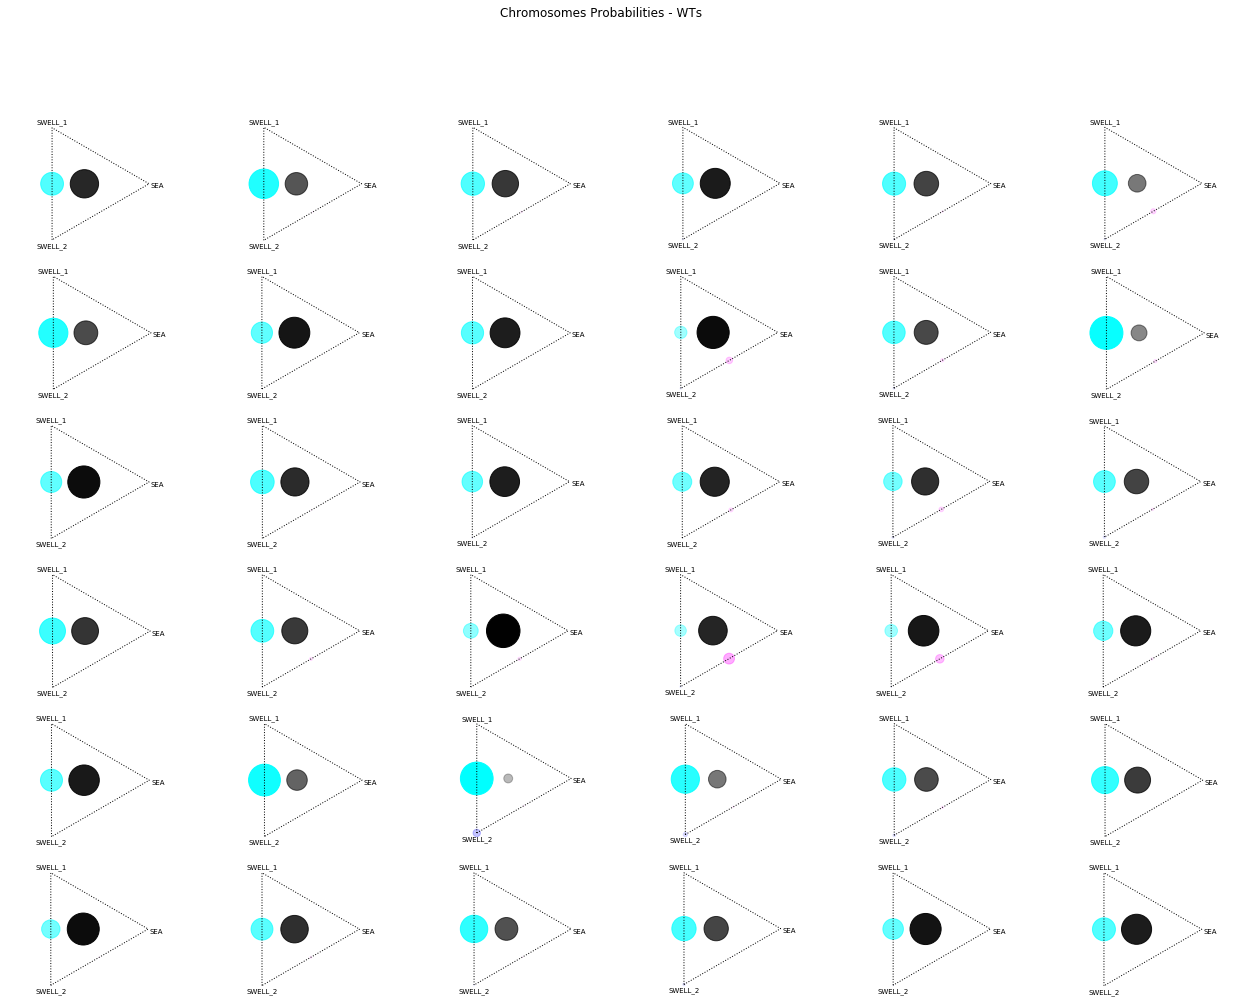

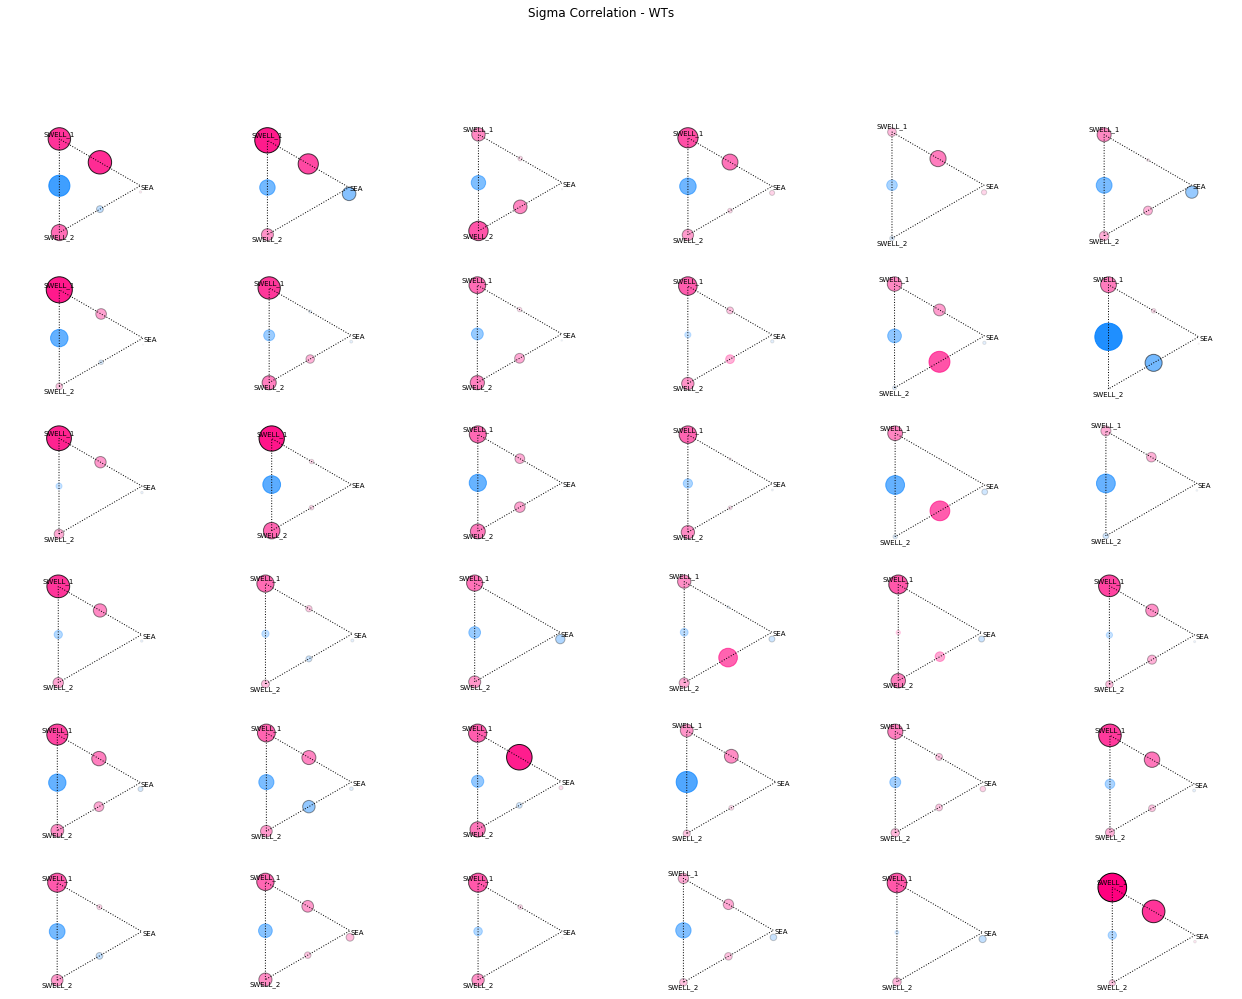

In [6]:
# Fit report figures
#CE = Climate_Emulator(p_ce)
#CE.Load()
CE.Report_Fit()


In [7]:
# TODO: ~10years and 3 simulations for testing, remove
xds_DWT = xds_DWT.isel(time=slice(0,365*10), n_sim=slice(0,2))


In [8]:
# --------------------------------------
#  Climate Emulator simulation (NO TCs)

# climate emulator object
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)
CE.Load()

# Simulate waves
ls_wvs_sim = CE.Simulate_Waves(xds_DWT, d_WTTCs)



Launching simulations...

C.E: Sim. Waves |██████████████████████████████████████████████████| 100.0% Complete

Launching simulations...

C.E: Sim. Waves |██████████████████████████████████████████████████| 100.0% Complete


In [9]:
# --------------------------------------
#  Climate Emulator simulation (TCs)

# climate emulator object
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)
CE.Load()

# Simulate TCs and update simulated waves
ls_tcs_sim, ls_wvs_upd = CE.Simulate_TCs(xds_DWT, d_WTTCs, xds_TCs_params, xds_TCs_RBFs, pchange_TCs, MU_WT, TAU_WT)


In [10]:
# --------------------------------------
#  Calculate Intradaily hydrographs for simulated storms

# iterate over simulations
for xds_wvs_sim, xds_tcs_sim in zip(ls_wvs_upd, ls_tcs_sim):
    
    # Aggregate waves families data 
    xds_wvs_agr = Aggregate_WavesFamilies(xds_wvs_sim)
    
    # calculate intradaily hydrographs
    xds_hg = Intradaily_Hydrograph(xds_wvs_agr, xds_tcs_sim)

    print(xds_hg)
    print()


<xarray.Dataset>
Dimensions:  (time: 87504)
Coordinates:
  * time     (time) datetime64[ns] 1700-01-01 ... 1709-12-25T23:00:00
Data variables:
    Hs       (time) float64 0.4678 1.133 1.118 1.104 ... 0.9552 0.9528 0.9504
    Tp       (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    Dir      (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    SS       (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

<xarray.Dataset>
Dimensions:  (time: 87576)
Coordinates:
  * time     (time) datetime64[ns] 1700-01-01 ... 1709-12-28T23:00:00
Data variables:
    Hs       (time) float64 1.321 1.347 1.373 1.398 ... 1.319 1.319 1.319 1.319
    Tp       (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    Dir      (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    SS       (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0



In [11]:
# --------------------------------------
# Calculate TWL annnual maxima

# iterate over simulations
for xds_wvs_sim in ls_wvs_upd:

    # Calculate TWL for waves families data 
    xds_TWL = TWL_WavesFamilies(xds_wvs_sim)

    # Calculate annual maxima (manually: time index not monotonic)
    xds_TWL_AnMax = TWL_AnnualMaxima(xds_TWL)
    
    print(xds_TWL_AnMax)
    print()
    

<xarray.Dataset>
Dimensions:  (time: 10)
Coordinates:
  * time     (time) datetime64[ns] 1700-10-03 1701-06-26 ... 1709-03-31
Data variables:
    Hs       (time) float64 4.936 3.591 3.218 2.119 ... 2.565 4.125 3.734 3.634
    Tp       (time) float64 11.63 12.22 11.75 14.35 ... 13.11 11.2 12.4 12.23
    Dir      (time) float64 67.8 17.29 65.91 358.9 ... 357.6 5.753 26.42 352.5
    TWL      (time) float64 1.388 1.244 1.132 1.122 ... 1.128 1.222 1.287 1.253

<xarray.Dataset>
Dimensions:  (time: 10)
Coordinates:
  * time     (time) datetime64[ns] 1700-08-25 1701-06-15 ... 1709-07-19
Data variables:
    Hs       (time) float64 3.08 3.259 2.137 2.583 ... 4.546 3.11 3.306 3.478
    Tp       (time) float64 11.5 14.18 15.77 12.48 ... 10.77 11.91 13.1 11.77
    Dir      (time) float64 293.6 5.133 66.33 40.65 ... 70.52 37.95 67.36 59.33
    TWL      (time) float64 1.084 1.375 1.238 1.077 ... 1.234 1.128 1.279 1.179

